## Identify Fraud from Enron Email by Steve T

### Abstract
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

### Project Goal
The goal for this project is to build a person of interest identifier based on the available financial and email data in the Enron scandal. Using machine learning we hope to build a model which is able to accurately predict if a person is a person of interest based on their email and financial data. Using the supervised classification in Machine Learning, we will attempt to fine tune the features and algorithm parameters to come up with a prediction score of 30% and above.

![title](enron_scandal.jpg)

### Dataset Overview
The dataset provided consists of a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity is provided along with the combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

> financial features: 
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

> email features: 
['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

> POI label: 
[‘poi’] (boolean, represented as integer)

### Understanding the Dataset and Question

In [1]:
import copy
import sys
sys.path.append("../tools/")
from poi_id import *
from tester import *

data_dict = load_data()

C:\Users\mela_\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Data Exploration 

In [2]:
features_list = select_features(data_dict, .5)
show_data_overview(data_dict, features_list)

Are there features with many missing values? etc.
  loan_advances :  142 ,Missing data percentage: 97.26 %
  director_fees :  129 ,Missing data percentage: 88.36 %
  restricted_stock_deferred :  128 ,Missing data percentage: 87.67 %
  deferral_payments :  107 ,Missing data percentage: 73.29 %
  deferred_income :  97 ,Missing data percentage: 66.44 %
  long_term_incentive :  80 ,Missing data percentage: 54.79 %
  bonus :  64 ,Missing data percentage: 43.84 %
  to_messages :  60 ,Missing data percentage: 41.1 %
  shared_receipt_with_poi :  60 ,Missing data percentage: 41.1 %
  from_this_person_to_poi :  60 ,Missing data percentage: 41.1 %
  from_poi_to_this_person :  60 ,Missing data percentage: 41.1 %
  from_messages :  60 ,Missing data percentage: 41.1 %
  other :  53 ,Missing data percentage: 36.3 %
  salary :  51 ,Missing data percentage: 34.93 %
  expenses :  51 ,Missing data percentage: 34.93 %
  exercised_stock_options :  44 ,Missing data percentage: 30.14 %
  restricted_stock :  

There's a total of 146 data points, and out of that number only 18 of them are Person of Interest vs 128 whom are non POIs. There's also a total of 21 features per data point.

Looking for incomplete or missing data in the dataset, we can see that there are a quite a few features which have higher than half of the data is missing or not available, if we intend to use these features to predict the POI the prediction would be highly inaccurate due to the high percentage of missing data. Thus using this as a starting point, we can eliminate those features that have 50% of more of the data that is not available as the first cut. And email address is also skipped because it's not a numeric value and we wouldn't be able to do any useful correlation analysis on it. By doing so we ended up with 14 features:
> bonus, to_messages, shared_receipt_with_poi, from_this_person_to_poi, from_poi_to_this_person, from_messages, other, salary, expenses, exercised_stock_options, restricted_stock, total_payments, total_stock_value, poi 

to continue the next data exploration stage with.

### Optimize Feature Selection/Engineering

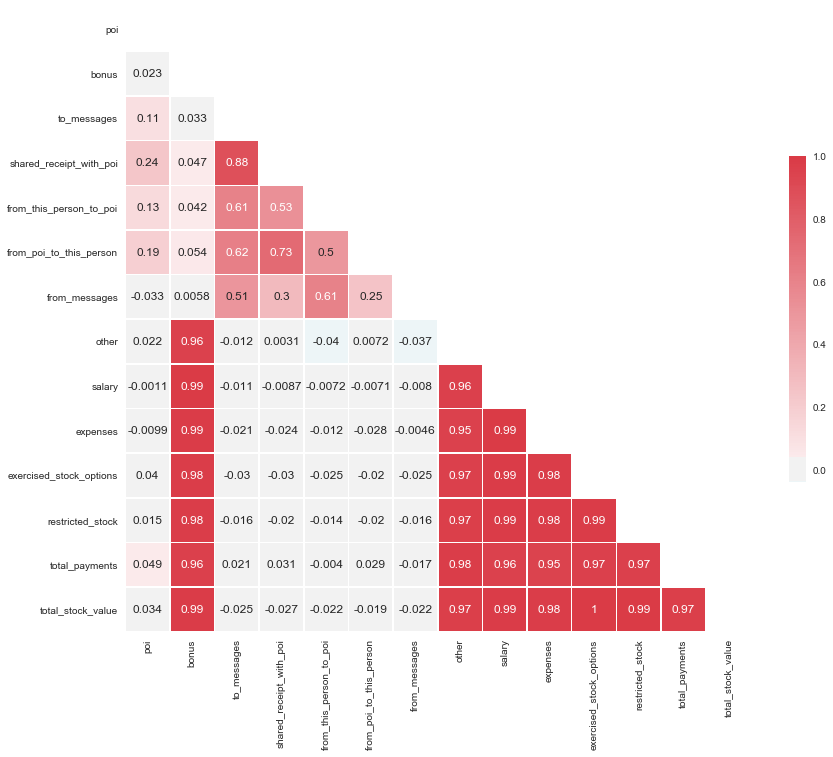

In [3]:
data = featureFormat(data_dict, features_list)
plotCorrMatrix(data, features_list)

After removing the features that have a higher number of missing data, we can start to analyse the highly correlated features by looking at the correlation matrix for the existing features and checking for the features that have a higher correlation with poi. The generated correlation matrix looks weird with high zero correlation for the features against poi. Let's try to plot the poi against total_payments to see if we're able to detect any anomalies in the data.

#### Outlier Investigation

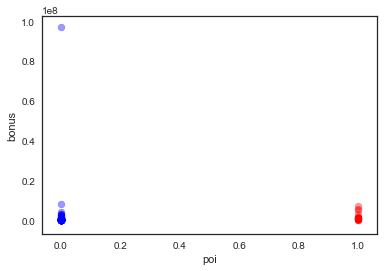

max salary:  ('TOTAL', {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'})


In [4]:
plotScatter(data,"poi", "bonus", 0, 1)
print "max salary: ", max(data_dict.items(), key=lambda(k,v):float(v['bonus']))

We did a exploratory scatterplot of the features to check for any outlier or basic patterns, and we found one obvious candidate which can be located way above the top left corner of the plot. The datapoints are marked in two colors, red for poi and and blue for non poi. Checking further into the value we can see that it belongs to the total row. This appears to be a spreadsheet inputting error and thus can be safely removed from the dataset.

Other potential irregularities that is worth removing are those data points that doesn't have any values in their financial data sheet, by narrowing does those data points that does't have any value in the total payments and the total stock value field, we can narrow down to this list of three person below. Based on the insider pay financial data sheet, we're able to see that for LOCKHART EUGENE E, there's no available data hence we would want to include this as another data point to be remove from further processing.

Based on the insider pay datasheet, we're able to find another datapoint which doesn't appear to be a person's name, THE TRAVEL AGENCY IN THE PARK, hence we would want to include this as another point to be removed.

In [5]:
for person, items in data_dict.items():
    if(items['total_payments'] == 'NaN' and items['total_stock_value'] == 'NaN'):
        print (person)

CHAN RONNIE
POWERS WILLIAM
LOCKHART EUGENE E


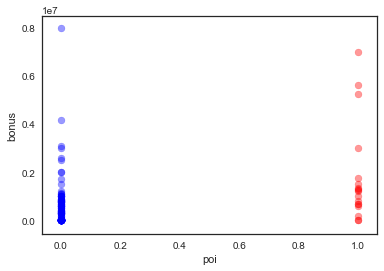

In [6]:
## removing outliers
clean_data_dict = data_dict
remove_outlier(clean_data_dict)

data = featureFormat(clean_data_dict, features_list)
plotScatter(data,"poi", "bonus", 0, 1)

After removing the outlier we ran the same scatterplot again and it appears to be much correct this time around. So let's first get back to the correlation matrix to see if we're better able to narrow down the list of highly correlated features.

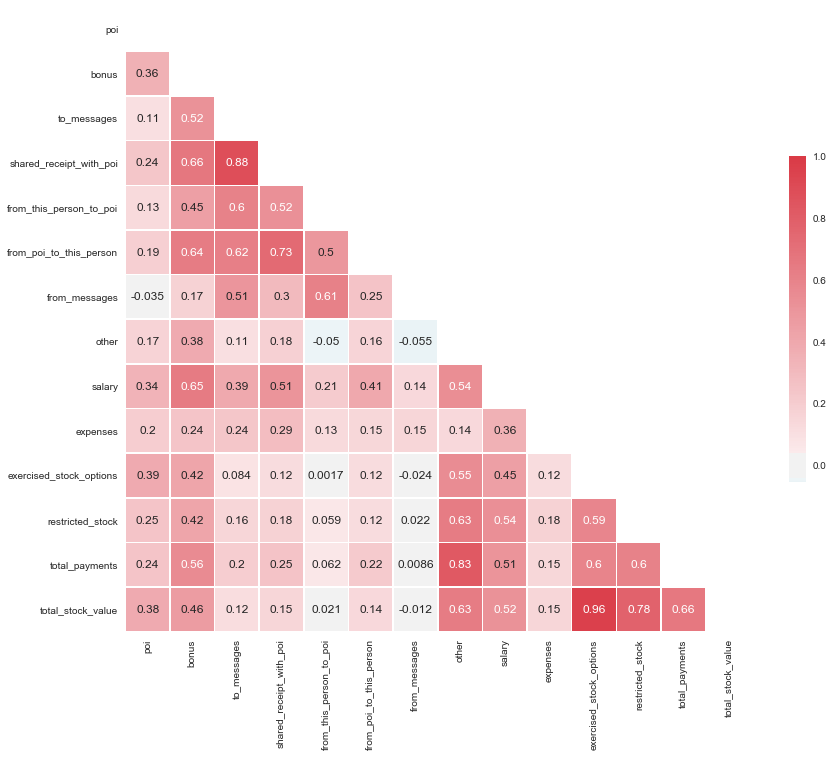

In [7]:
plotCorrMatrix(data, features_list)

And indeed, the correlation matrix now shows a more useful data. Allowing us to group the features correlated to poi to a few groups from zero correlation to high correlation. Surprisingly though, we can see that the from_messages feature has zero correlation to poi. Thus let's begin by looking at other features which are highly correlated (>=0.19) to poi and check for useful hint on how to proceed with the features selection.

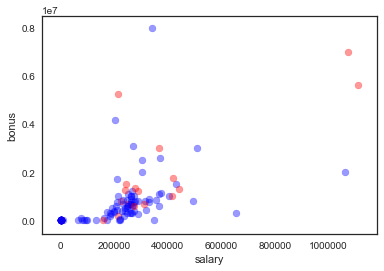

In [8]:
plotScatter(data,"salary", "bonus", 8, 1)

Looking the salary against the bonus scatterplot, we don't see a very strong pattern to detect POI even if we choose to ignore the outliers values to the right of the plot. Then again in terms of the distribution of the data that may be because we don't have enough poi data to see a clearer trend. Let's try to do a few more scatterplots to see if we can get to see a clearer pattern in some other plots.

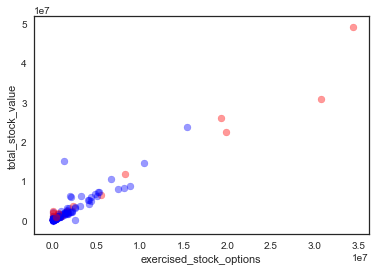

In [9]:
plotScatter(data,"exercised_stock_options", "total_stock_value", 10, 13)

The plot for total_stock_value and the exercised_stock_options look pretty promising which we can see that the poi points appears on the right hand side of the plot although we still see values being mixed on the left side of the plot. This could be useful features that we can try to explore further using Machine Learning.
Moving onto the next pair of features which shows higher correlation.

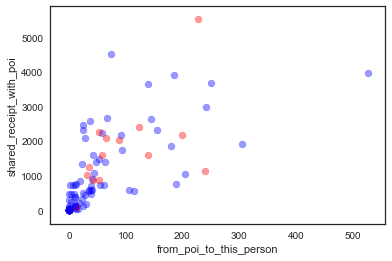

In [10]:
plotScatter(data,"from_poi_to_this_person", "shared_receipt_with_poi", 5, 3)

For the from_poi_to_this_person against shared_receipt_with_poi scatterplot, we're not seeing any clearer pattern as well. So let's look at what other features that we can engineer here which would show even higher correlation that what we've seen so far.


#### Create new features

Based on my intuition, I've devised five new features to add to the analysis. The general idea was to find ratio of the emails received or sent to a poi and based on that try to determine if that person himself or herself can also be a poi. And the second approach was to use a total of the either the salary, bonus and the total stock value to determine if those people who have received a total amount of money would be useful in helping us to identify if that person could be a poi.
1. ratio_from_poi_fr_msg - Ratio showing the number of email messages from a poi vs total messages this person have received.
1. ratio_to_poi_to_msg - Ratio showing the number of email messages that this person have sent to a poi vs all the email messages that they have sent.
1. total_to_poi_from_poi - Using the above two ratio and combining those two values to see if we're able to get a stronger indicator with this variable.
1. total_salary_stock - Total of the salary plus total stock value, checking correlation for just salary plus the stock value
1. total_bonus_stock - Repeating the same as above but replacing salary with bonus.

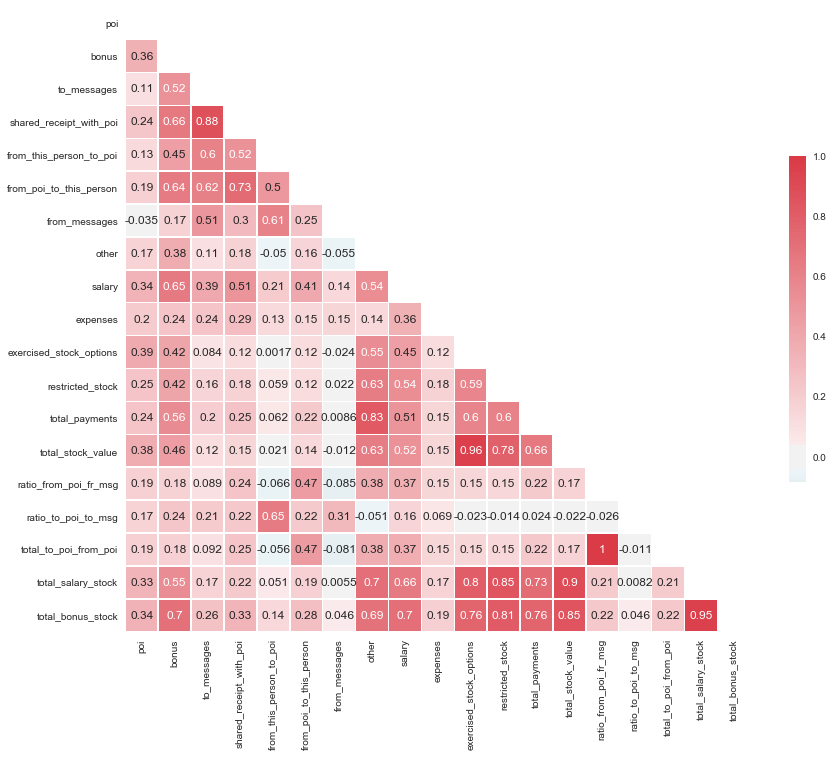

In [11]:
# make a deep copy for the feature list so that it doesn't get overwritten
new_feature_list = copy.deepcopy(features_list)
clean_data_dict, new_features_list = create_new_features(clean_data_dict, new_feature_list)
data = featureFormat(clean_data_dict, new_features_list)
plotCorrMatrix(data, new_features_list)

Rerunning the correlation matrix shows that even with the total salary stock and total bonus stock, the correlation value we received for those two, .33 and .34 is no better than the individual variable, salary - .34, bonus - .36, total stock value - .38 and exercised stock option - .39 before any additional division or addition. Hence moving forward we want to attempt to use the automatic feature selection method to see if we can do better.

#### Assessing impact of newly engineered features
We're going to be utilising the select kbest function and the anova f-stat to get the scoring for our features and also to compare the scores that we get from the new features.

In [12]:
features, labels, sel_features_list = autoselect_features(clean_data_dict, features_list, 'all')

SelectKBest scores:  [('exercised_stock_options', 24.8151), ('total_stock_value', 24.1829), ('bonus', 20.7923), ('salary', 18.2897), ('restricted_stock', 9.2128), ('total_payments', 8.7728), ('shared_receipt_with_poi', 8.5894), ('expenses', 6.0942), ('from_poi_to_this_person', 5.2434), ('other', 4.1875), ('from_this_person_to_poi', 2.3826), ('to_messages', 1.6463), ('from_messages', 0.1697)]


In [13]:
accuracy, precision, recall = get_features_score(features, labels)
print 'initial list',accuracy, precision, recall

initial list 0.7907 0.54808 0.52976


Using the existing features list, we ran this through a K-nearest neighbour classifier to assess the initial accuracy, precision and recall scores. Based on this classifier, we're able to get an accuracy score of .7907, precision of .54808 and recall of .52976

In [14]:
final_features, labels, sel_features_list = autoselect_features(clean_data_dict, new_features_list, 'all')

SelectKBest scores:  [('exercised_stock_options', 24.8151), ('total_stock_value', 24.1829), ('bonus', 20.7923), ('total_bonus_stock', 18.8631), ('salary', 18.2897), ('total_salary_stock', 17.595), ('restricted_stock', 9.2128), ('total_payments', 8.7728), ('shared_receipt_with_poi', 8.5894), ('expenses', 6.0942), ('total_to_poi_from_poi', 5.2743), ('from_poi_to_this_person', 5.2434), ('ratio_from_poi_fr_msg', 5.1239), ('other', 4.1875), ('ratio_to_poi_to_msg', 4.0947), ('from_this_person_to_poi', 2.3826), ('to_messages', 1.6463), ('from_messages', 0.1697)]


We can see that the f-stat scoring that we received from the five new features are as follows total_bonus_stock: 18.8631, total_salary_stock: 18.2897, total_to_poi_from_poi: 5.2743, ratio_from_poi_fr_msg: 5.1239 and ratio_to_poi_to_msg: 4.0947.
Two of the newly engineered features appears to be in the top ten of the features list based on this scoring.
Let's check the accuracy, precision and recall scoring by running through the same classifier.

In [15]:
accuracy, precision, recall = get_features_score(final_features, labels)
print 'new features list',accuracy, precision, recall

new features list 0.7907 0.41463 0.47222


I was actually expecting to get a slightly higher value for accuracy, precision and recall running it against the same classifier, but the result shows that we're actually getting weaker precision and recall scores of .41463 and .47222 with the same accuracy score of .7907.
So the new features definitely have an impact but we probably need to do an additional filtering and not using the list completely.

#### Intelligently select features

So I'm going to use select k best once again to help me optimize the number of features to use from our current features list.

In [16]:
dr = []
for k in range(2,len(new_features_list)):
    features, labels, sel_features_list = autoselect_features(clean_data_dict, new_features_list, k, False)
    accuracy, precision, recall = get_features_score(features, labels)
    dr.append([k,accuracy, precision, recall])
    
print pd.DataFrame(dr, columns=['k','accuracy','precision','recall'])

     k  accuracy  precision   recall
0    2   0.83721    0.68590  0.61508
1    3   0.83721    0.68590  0.61508
2    4   0.83721    0.68590  0.61508
3    5   0.83721    0.68590  0.61508
4    6   0.79070    0.41463  0.47222
5    7   0.83721    0.67683  0.55754
6    8   0.81395    0.59167  0.54365
7    9   0.81395    0.59167  0.54365
8   10   0.81395    0.59167  0.54365
9   11   0.81395    0.59167  0.54365
10  12   0.81395    0.59167  0.54365
11  13   0.81395    0.59167  0.54365
12  14   0.79070    0.41463  0.47222
13  15   0.79070    0.41463  0.47222
14  16   0.79070    0.41463  0.47222
15  17   0.79070    0.41463  0.47222
16  18   0.79070    0.41463  0.47222


By mapping all the k from 2 all the way to the max number of features which is 18, we're able to easily compare the most optimal k value in terms of max accuracy, precision and recall scoring to be used for the next section. Since the max accuracy, precision and recall scores that we're able to achieve is .83721, .6859 and .61508 and this happens when k = 2 to k = 5, we're going to be using the largest k value so that we have more parameters to play with in the parameters tuning section.

In [17]:
final_features, labels, sel_features_list = autoselect_features(clean_data_dict, new_features_list, 5, False)
# including poi in the full final features list
final_features_list =  ['poi']+sel_features_list[0:len(sel_features_list):1]
print final_features_list

['poi', 'bonus', 'salary', 'exercised_stock_options', 'total_stock_value', 'total_bonus_stock']


The final features list based on select k best is 'bonus', 'salary', 'exercised_stock_options', 'total_stock_value', 'total_bonus_stock'.

#### Properly scale features
The five selected features are all monetary amount and in terms of the number, they are closer in range but regardless depending on the classifier that we will be chosing for the next section, it's better that we run this through a feature scaling to ensure that any outliers can be handled and to avoid any negative values from the dataset when running the dataset through different ML algorithms later.
So we'll be running through three different types of feature scaling and checking the accuracy, precision and recall scoring again based on the k-nearest neighbour classifier.

In [18]:
scaled_features = apply_minmax_feature_scaling(final_features)
accuracy, precision, recall = get_features_score(scaled_features, labels)
print 'minmax',accuracy, precision, recall

scaled_features = apply_standard_feature_scaling(final_features)
accuracy, precision, recall = get_features_score(scaled_features, labels)
print 'standard',accuracy, precision, recall

scaled_features = apply_robust_feature_scaling(final_features)
accuracy, precision, recall = get_features_score(scaled_features, labels)
print 'robust',accuracy, precision, recall

minmax 0.81395 0.59167 0.54365
standard 0.83721 0.6859 0.61508
robust 0.86047 0.77083 0.62897


Based on the above, we're going to be using the robust scaler for the feature scaling and using the scaled values to pick to compare against a few machine learning algorithms so that we can proceed to choose a final classifier to continue testing with.

### Pick and Tune an Algorithm

#### Validation
In order to avoid creating a model that is able to predict too well using the test data but not able to do well at all using other than the test data as the test data, we need to incorporate a validation strategy into our model building. In short what we hope to achieve here is to avoid overfitting. 

Thus we are going to be using a holdout strategy here by reserving a small part of the original training data, 30%, to be use as test data to predict the correctness of our model once the original model is use to fit with the training data. This will help to eliminate the issue of information leakage by allowing the model to overfit by gaining insights into the whole dataset which includes the final validation dataset.

There's also the potential issue of high variance which can be introduced during the cross validation, if the sample selected from the validation strategy is skewed in some way, but this can be taken care of in the next section, when we will rerun the dataset against the Stratified Shuffle split which will attempt first randomize the data before grouping them into a specific target oriented class to minimize the variance.

In [19]:
(features_train,features_test,labels_train,labels_test,sc_features_train,sc_features_test,sc_labels_train,sc_labels_test) \
= apply_cross_validation(final_features, labels, scaled_features)

#### Pick an algorithm 

Based on a machine learning algorithm selection cheat sheet$^{[7]}$, I've narrow down the selection to four algorithms to use on the dataset. I would be using Linear Support Vector Classification, KNeighbours Classifier, Naive Bayes and Random Forest. 

Here are the basic definitions of what these three scores are referring to:
> The accuracy refers to the accuracy classification score.

> The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

>The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

Based on the above definition, we can understand that the accuracy reflects how correct our model is in classifying poi as poi and non poi as non poi out all of the whole dataset. And the precision here measures how well our model is able to predict poi as poi and keeping the number of non poi which are labelled as poi to a minimum. Thirdly the recall refers to how well the model is able to correctly identify all the actual poi out of the whole poi dataset.

In [20]:
clfs = apply_classifiers()

In [21]:
datamatrix = compare_algorithms(clfs, features_train, labels_train, features_test, labels_test, sc_features_train, \
                                sc_labels_train,sc_features_test, sc_labels_test)
pd.DataFrame (datamatrix, columns=['Algorithm','accuracy', 'precision', 'recall','sc_accuracy', 'sc_precision', 'sc_recall'])

,Algorithm,accuracy,precision,recall,sc_accuracy,sc_precision,sc_recall
0,LinearSVC,0.86047,0.92857,0.57143,0.88372,0.93902,0.64286
1,KNearestNeighbour,0.83721,0.68590,0.61508,0.86047,0.77083,0.62897
2,NaiveBayes,0.83721,0.68590,0.61508,0.83721,0.68590,0.61508
3,RandomForest,0.86047,0.74737,0.68651,0.86047,0.74737,0.68651


Running the Linear SVC, we're getting a score reading of .86047, .92857 and .57143 for accuracy, precision and recall. Comparing these numbers to the scaled features data, we're seeing slight improvement across the accuracy, precision and the recall score values to .88372, .93902 and .64286.

Moving onto the next algorithm, we're using K-nearest neighbours to check if we're able to get a better precision and recall value than Linear SVC. Using this algorithm, we're getting .83721 for accuracy, .6859 and .61508 for both precision and recall. We're seeing improvement across the three scores with .86047, .77083 and .62897 for accuracy, precision and recall. In terms of precision and recall scores, it's scoring higher than Linear SVC.

Next onto Naive Bayes as the algorithm, first going through the unscaled features dataset, we're scoring .83721, .6859 and .61508 for the accuracy, precision and recall. We're getting the same scores for the scaled features. For the unscaled features, we're getting the same scores as k-nearest neighbour but for the scaled features, the precision and recall for k-nearest neighbour classifier is higher.

Lastly, we're going to apply RandomForest on the dataset. With this ensemble algorithm, we're getting an accuracy, precision and recall scores of .86047, .74737 and .68651. For the scaled features, we're getting the same scores as well. The unscaled features model has a higher precision and recall out of the four algorithms compared here but in terms of scaled features, the precision is lower than k-nearest but it has a higher recall score than k-nearest.

#### Tuning algorithms
So far we have done feature scaling and tried a few machine learning algorithms to train the data and checking the resulting accuracy, precision and recall scores, we're getting decent scores, but we can further fine tune the parameters for the corresponding learning algorithms to tweak it so that we can get a higher accuracy, precision and recall score values. Without proper parameters tuning, we could end up with a model which underfit and doesn't do well in handling new data.

I'm using the GridSearchCV to help me roughly narrow down the significant parameters and it's range, and further manually tweaking it a bit by setting the parameter value range and checking the scores. With these few rounds of trial and error tweaking, we hope to further increase the scores of these models. And any gain in the accuracy, precision or recall of the models is further enlarged depending on how the model is used. For example, an improvement of 1% in the accuracy would mean that we're better able to identify one more POI out of a line up of 100 person.

In [22]:
tuned_clfs = tune_classifier(features_train, labels_train)

Best estimator found by grid search:
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 

Best estimator found by grid search:
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance') 

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 



Onto the task of tuning the parameters:
For LinearSVC, the available parameters for tuning are quite restricted, so I just play with the C parameter by providing a rough range and allowing the GridSearch to point me to the direction of the final value to be use. The C parameter defines for the SVM the level of misclassification that is acceptable, a large C value will allow for a closer fit to be generated and thus less misclassification issue.

For Naive Bayes, we don't need to do any parameter tuning hence we can skip to the next one.

On K Nearest Neighbour, the parameters selected are n_neighbours, weights and algorithms. We're trying to build the best model by using the number of nearest neighbours, the algorithms used to compute the nearest neighbour and weights - which emphasize either equal distribution or more emphasis are given to closer neighbours.

And finally to Random Forest, we're tweaking n estimators - defines number of trees in the forest.

In [23]:
datamatrix = compare_algorithms(tuned_clfs, features_train, labels_train, features_test, labels_test, sc_features_train, \
                                sc_labels_train,sc_features_test, sc_labels_test)
pd.DataFrame (datamatrix, columns=['Algorithm','accuracy', 'precision', 'recall','sc_accuracy', 'sc_precision', 'sc_recall'])

,Algorithm,accuracy,precision,recall,sc_accuracy,sc_precision,sc_recall
0,Tuned LinearSVC,0.81395,0.63421,0.60119,0.88372,0.93902,0.64286
1,Tuned KNearestNeighbour,0.83721,0.69595,0.67262,0.83721,0.69595,0.67262
2,Tuned RandomForest,0.86047,0.74737,0.68651,0.86047,0.74737,0.68651


##### After tuning the parameters, let's check the results again.
For the Linear SVC, the accuracy appears to have worsen to .81395 along with the precision to .63421 but recall improved to .60119 .However using the scaled features, we're getting the same score as the pre-tuned tuned classifier, with a score reading of .88372, .93902 and .64286 for accuracy, precision and recall. 

Moving onto the next algorithm, K-nearest neighbours, the accuracy score of .83721 was maintained and we see improvements in both precision and recall with score of .69595 and .67262. These scores were returned unimproved for the scaled features dataset.

Lastly, comparing the RandomForest classifier, we're getting the same accuracy, precision and recall scores as before the parameters tuning, I've randomly trial and error different parameters setting but wasn't able to get a better score than .86047, .74737 and .68651.

### Evaluation
For the evaluation, we're going to run the same set of classifiers using a stratified shuffle split to eliminate the bias against the dataset and to check which algorithms will yield the best scores in terms of recall and precision according to the project rubric. 

In [25]:
test_algorithms(clfs, clean_data_dict, final_features_list)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.71669	Precision: 0.23037	Recall: 0.35950	F1: 0.28080	F2: 0.32326
	Total predictions: 13000	True positives:  719	False positives: 2402	False negatives: 1281	True negatives: 8598

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')
	Accuracy: 0.85754	Precision: 0.56839	Recall: 0.30750	F1: 0.39909	F2: 0.33858
	Total predictions: 13000	True positives:  615	False positives:  467	False negatives: 1385	True negatives: 10533

GaussianNB(priors=None)
	Accuracy: 0.83685	Precision: 0.45195	Recall: 0.28450	F1: 0.34919	F2: 0.30727
	Total predictions: 13000	True positives:  569	False positives:  690	False negatives: 1431	True negatives: 10310

RandomForestClassifi

Using the Stratified Shuffle split to run the dataset against, we're getting lower scores this around, and we're also seeing a few new scores which can be defined as follows:
> The F1-Score is the harmonic mean of precision and recall

> The F2-Score is a weighted average of precision and recall

Both of these scores measures both recall and precision as a combined score as there's always a tradeoff in getting a higher value in either one of these score, thus a higher F1 or F2 score can encapsulate both the precision and recall factor for a particular model. But for the rest of the evaluation, we will be narrowing it down to just the precision and recall scores.

Comparing against the four classifiers above, we can clearly see that the K nearest neighbour have the the highest precision and recall score, getting a decent .56839 and .3075. 
The second highest score goes to the Random Forest classifier with a precision and recall score of .53892 and .2375.
This is followed by naive bayes classifier with a precision and recall score of .45195 and .2845.
And finally by Linear Support Vector classifier with a precision and recall score of .23037 and .3595.

In [26]:
test_algorithms(tuned_clfs, clean_data_dict, final_features_list)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.70492	Precision: 0.22695	Recall: 0.38150	F1: 0.28460	F2: 0.33577
	Total predictions: 13000	True positives:  763	False positives: 2599	False negatives: 1237	True negatives: 8401

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance')
	Accuracy: 0.85846	Precision: 0.55000	Recall: 0.44000	F1: 0.48889	F2: 0.45833
	Total predictions: 13000	True positives:  880	False positives:  720	False negatives: 1120	True negatives: 10280

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_

After fine tunning the parameters, we're able to get a decent score for the K-nearest neighbours classifier, with a precision and recall score of .55 and .44, improving on the recall score but getting a slight hit on the precision score.
For random forest classifier, we're getting slightly worsening scores in the precision and accuracy with a score of .53715 and .2675.
And lastly for linear support vector classifier, we're also seeing worsening precision but still an improved recall with the score of .23426 and .387

Based on these scores, the final selected classifier would be the k-nearest neighbour classifier. And with it we're able to avoid misclassifying non poi 55% of the time and is able to correctly find all the poi out of a line up which include non poi labelled as poi, 44% of the time.

### Reflection
The final precision and recall score for the selected classifier is still quite limited, we can probably do better if we're able to gather more data points which can help to build a stronger pattern recognition for our model. Due to time restriction, we also choose to tune the parameters to get a good enough setting for at least one of the classifier to ensure that the precision and recall scores are over .3, given more time and analysis, we should be able to further improve these scores.

In [27]:
# dumping the settings for external testing
final_clf = tuned_clfs['Tuned KNearestNeighbour']
dump_classifier_results(final_clf, clean_data_dict, final_features_list)

In [28]:
f_clf, f_dataset, f_feature_list = load_classifier_and_data()
test_classifier(f_clf, f_dataset, f_feature_list)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance')
	Accuracy: 0.85846	Precision: 0.55000	Recall: 0.44000	F1: 0.48889	F2: 0.45833
	Total predictions: 13000	True positives:  880	False positives:  720	False negatives: 1120	True negatives: 10280



### Questions for the project:

1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]
1. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]
1. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]
1. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]
1. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]
1. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

### References:
1. Project rubric - https://review.udacity.com/#!/rubrics/27/view
1. Project questions - https://docs.google.com/document/d/1NDgi1PrNJP7WTbfSUuRUnz8yzs5nGVTSzpO7oeNTEWA/pub?embedded=true
1. Working with missing values - https://pandas.pydata.org/pandas-docs/stable/missing_data.html
1. Feature selection - https://machinelearningmastery.com/feature-selection-machine-learning-python/
1. What is a F stat value - http://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/
1. Feature scaling - http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
1. ML Algorithm selection - http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
1. Comparing preprocessing - http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
1. Preprocessing data - http://scikit-learn.org/stable/modules/preprocessing.html
1. Scaling features - https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re
1. Feature selection vs PCA - https://stats.stackexchange.com/questions/182711/principal-component-analysis-vs-feature-selection
1. Influence of C in SVC - https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
1. bayesian optimisation - https://thuijskens.github.io/2016/12/29/bayesian-optimisation/
1. common problem in hyperparameters optimisation - https://blog.sigopt.com/posts/common-problems-in-hyperparameter-optimization
1. test vs validation dataset - https://machinelearningmastery.com/difference-test-validation-datasets/
1. cross validation strategies - https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f
1. how to interpret f1-score - https://stats.stackexchange.com/questions/49226/how-to-interpret-f-measure-values
1. feature scaling and it's affect - https://stackoverflow.com/questions/26668316/effect-of-feature-scaling-on-accuracy
1. class imbalance problem - http://www.chioka.in/class-imbalance-problem/
1. pep 257 - https://terrameijar.wordpress.com/2017/01/26/a-summary-of-pep-8-style-guide-for-python-code-and-pep-257-docstring-conventions/
1. understanding anova f test - http://www.thejuliagroup.com/blog/?p=2855
1. visualizing gridsearch scores result - https://www.kaggle.com/hadend/tuning-random-forest-parameters